
Extracting ./data/cifar-10-python.tar.gz to ./data/

CIFAR-10 Custom CNN #1: 

Epoch 1:
Train Loss: 0.0466, Train Acc: 44.69
Test Loss: 0.0663, Test Acc: 27.12
Epoch 2:
Train Loss: 0.0293, Train Acc: 66.78
Test Loss: 0.0513, Test Acc: 44.82
Epoch 3:
Train Loss: 0.0227, Train Acc: 74.49
Test Loss: 0.0535, Test Acc: 49.89
Epoch 4:
Train Loss: 0.0184, Train Acc: 79.33
Test Loss: 0.0490, Test Acc: 49.63
Epoch 5:
Train Loss: 0.0150, Train Acc: 83.02
Test Loss: 0.0432, Test Acc: 56.94
Epoch 6:
Train Loss: 0.0122, Train Acc: 86.12
Test Loss: 0.0593, Test Acc: 46.96
Epoch 7:
Train Loss: 0.0098, Train Acc: 88.78
Test Loss: 0.0603, Test Acc: 49.53
Epoch 8:
Train Loss: 0.0082, Train Acc: 90.65
Test Loss: 0.0513, Test Acc: 56.56
Epoch 9:
Train Loss: 0.0072, Train Acc: 92.08
Test Loss: 0.0640, Test Acc: 49.24
Epoch 10:
Train Loss: 0.0062, Train Acc: 93.11
Test Loss: 0.0573, Test Acc: 52.00


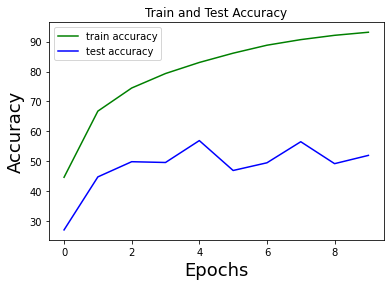

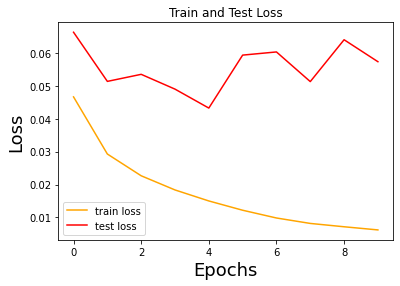

In [ ]:
# First attempt: Custom CNN ~51% test accuracy ~93% train accuracy **OVERFITTING**
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# Structure: conv-> conv-> maxpool-> conv-> conv-> maxpool-> conv-> conv-> maxpool-> linear-> linear-> output
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.network = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # Conv layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # pooling layer 3
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            # Conv layer 4
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Conv layer 5
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # pooling layer 6
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            # conv layer 7
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # conv layer 8
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # pooling layer 9
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Flatten(),
            # linear layer 10 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            # linear layer 11
            nn.Linear(1024, 512),
            nn.ReLU(),
            # output layer 12
            nn.Linear(512, 10))
        
    def forward(self, x):
        return self.network(x)

    
print('\nCIFAR-10 Custom CNN #1: \n')    
model_conv = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)
          
def train_model(model, train_loader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # get image and label from data
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # reset gradients to zero

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards propogate and optimize
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)
    print('Train Loss: {:.4f}, Train Acc: {:.2f}'.format(train_loss, train_accuracy))
    
    return train_loss, train_accuracy


def evaluate_model(model, test_loader):
    model.eval()
    test_total_loss = 0.0
    test_total_correct = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # compute loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # add up loss and amount correct
        test_total_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        test_total_correct += (preds == labels).sum().item()
    
    test_avg_loss = test_total_loss/len(test_loader.dataset)
    test_accuracy = 100. * test_total_correct/len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Acc: {:.2f}'.format(test_avg_loss, test_accuracy))
    
    return test_avg_loss, test_accuracy

# train and evaluate model
train_loss , train_accuracy = [], []
test_loss , test_accuracy = [], []
for epoch in range(num_epochs):
    print('Epoch {}:'.format(epoch+1))
    train_epoch_loss, train_epoch_accuracy = train_model(model_conv, train_loader)
    test_epoch_loss, test_epoch_accuracy = evaluate_model(model_conv, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

# plot accuracy graphs
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(test_accuracy, color='blue', label='test accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

# plot loss graphs
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(test_loss, color='red', label='test loss')
plt.legend()
plt.title('Train and Test Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


Files already downloaded and verified

CIFAR-10 Custom CNN #2: 

Epoch 1:
Train Loss: 0.0469, Train Acc: 45.19
Test Loss: 0.0591, Test Acc: 32.16
Epoch 2:
Train Loss: 0.0323, Train Acc: 64.04
Test Loss: 0.0586, Test Acc: 38.99
Epoch 3:
Train Loss: 0.0253, Train Acc: 72.46
Test Loss: 0.0551, Test Acc: 40.91
Epoch 4:
Train Loss: 0.0213, Train Acc: 76.63
Test Loss: 0.0658, Test Acc: 39.60
Epoch 5:
Train Loss: 0.0179, Train Acc: 80.31
Test Loss: 0.0522, Test Acc: 46.00
Epoch 6:
Train Loss: 0.0154, Train Acc: 83.18
Test Loss: 0.0451, Test Acc: 53.48
Epoch 7:
Train Loss: 0.0136, Train Acc: 85.06
Test Loss: 0.0489, Test Acc: 50.85
Epoch 8:
Train Loss: 0.0118, Train Acc: 87.10
Test Loss: 0.0566, Test Acc: 45.56
Epoch 9:
Train Loss: 0.0105, Train Acc: 88.33
Test Loss: 0.0585, Test Acc: 48.70
Epoch 10:
Train Loss: 0.0093, Train Acc: 89.92
Test Loss: 0.0494, Test Acc: 55.53


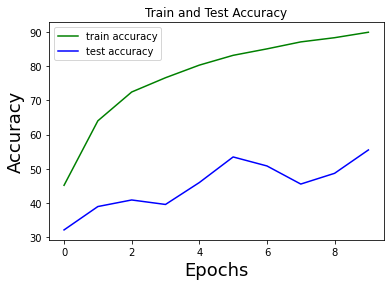

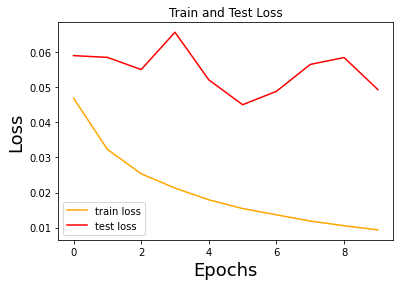

In [ ]:
# Second attempt: Custom CNN ~52% test accuracy ~87% train accuracy **OVERFITTING**
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
# Structure conv-> conv-> maxpool-> dropout-> conv-> conv-> maxpool-> dropout -> linear-> linear-> dropout-> output
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(192, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(8*8*256, 512)
        self.fc2 = nn.Linear(512, 64)
        self.Dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.Dropout(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.Dropout(x)
        x = x.view(-1, 8*8*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.Dropout(x)
        x = self.fc3(x)
        return x

    
print('\nCIFAR-10 Custom CNN #2: \n')    
model_conv = ConvNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)
          
def train_model(model, train_loader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # get image and label from data
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # reset gradients to zero

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards propogate and optimize
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)
    print('Train Loss: {:.4f}, Train Acc: {:.2f}'.format(train_loss, train_accuracy))
    
    return train_loss, train_accuracy


def evaluate_model(model, test_loader):
    model.eval()
    test_total_loss = 0.0
    test_total_correct = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # compute loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # add up loss and amount correct
        test_total_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        test_total_correct += (preds == labels).sum().item()
    
    test_avg_loss = test_total_loss/len(test_loader.dataset)
    test_accuracy = 100. * test_total_correct/len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Acc: {:.2f}'.format(test_avg_loss, test_accuracy))
    
    return test_avg_loss, test_accuracy

# train and evaluate model
train_loss , train_accuracy = [], []
test_loss , test_accuracy = [], []
for epoch in range(10):
    print('Epoch {}:'.format(epoch+1))
    train_epoch_loss, train_epoch_accuracy = train_model(model_conv, train_loader)
    test_epoch_loss, test_epoch_accuracy = evaluate_model(model_conv, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

# plot accuracy graphs
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(test_accuracy, color='blue', label='test accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

# plot loss graphs
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(test_loss, color='red', label='test loss')
plt.legend()
plt.title('Train and Test Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


Extracting ./data/cifar-10-python.tar.gz to ./data/


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth




CIFAR-10 AlexNet: 

Epoch 1:
Train Loss: 0.0424, Train Acc: 52.09
Test Loss: 0.0228, Test Acc: 74.61
Epoch 2:
Train Loss: 0.0226, Train Acc: 74.45
Test Loss: 0.0183, Test Acc: 79.24
Epoch 3:
Train Loss: 0.0187, Train Acc: 79.24
Test Loss: 0.0166, Test Acc: 81.69
Epoch 4:
Train Loss: 0.0167, Train Acc: 81.52
Test Loss: 0.0163, Test Acc: 82.25
Epoch 5:
Train Loss: 0.0151, Train Acc: 83.24
Test Loss: 0.0145, Test Acc: 83.69
Epoch 6:
Train Loss: 0.0140, Train Acc: 84.44
Test Loss: 0.0134, Test Acc: 84.86
Epoch 7:
Train Loss: 0.0131, Train Acc: 85.57
Test Loss: 0.0131, Test Acc: 85.56
Epoch 8:
Train Loss: 0.0123, Train Acc: 86.52
Test Loss: 0.0136, Test Acc: 85.09
Epoch 9:
Train Loss: 0.0117, Train Acc: 86.94
Test Loss: 0.0122, Test Acc: 86.52
Epoch 10:
Train Loss: 0.0111, Train Acc: 87.64
Test Loss: 0.0128, Test Acc: 85.93


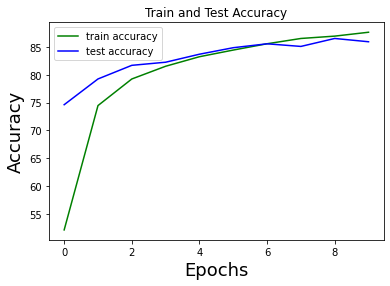

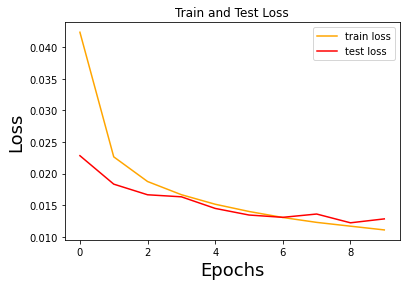

In [ ]:
# AlexNet CNN

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc

# prevents error out of memory
gc.collect()
torch.cuda.empty_cache()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Image preprocessing modules
# crop to 256 X 256
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])



# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transform)      #transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# using AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)


AlexNet_model.to(device) # set model to device

# update first classifier
AlexNet_model.classifier[1] = nn.Linear(9216,4096)

# update second classifier
AlexNet_model.classifier[4] = nn.Linear(4096, 1024)

# update last classifier to output 10 classes
AlexNet_model.classifier[6] = nn.Linear(1024, num_classes)

AlexNet_model.to(device) # set model to device

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(AlexNet_model.parameters(), lr=learning_rate)

print('\nCIFAR-10 AlexNet: \n')

def train_model(model, train_loader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # get image and label from data
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards propogate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)
    print('Train Loss: {:.4f}, Train Acc: {:.2f}'.format(train_loss, train_accuracy))
    
    return train_loss, train_accuracy


def evaluate_model(model, test_loader):
    model.eval()
    test_total_loss = 0.0
    test_total_correct = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # compute loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # add up loss and amount correct
        test_total_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        test_total_correct += (preds == labels).sum().item()
    
    test_avg_loss = test_total_loss/len(test_loader.dataset)
    test_accuracy = 100. * test_total_correct/len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Acc: {:.2f}'.format(test_avg_loss, test_accuracy))
    
    return test_avg_loss, test_accuracy

# train and evaluate model
train_loss , train_accuracy = [], []
test_loss , test_accuracy = [], []
for epoch in range(10):
    print('Epoch {}:'.format(epoch+1))
    train_epoch_loss, train_epoch_accuracy = train_model(AlexNet_model, train_loader)
    test_epoch_loss, test_epoch_accuracy = evaluate_model(AlexNet_model, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

# plot accuracy graphs
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(test_accuracy, color='blue', label='test accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

# plot loss graphs
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(test_loss, color='red', label='test loss')
plt.legend()
plt.title('Train and Test Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth




CIFAR-10 ResNet18: 

Epoch 1:
Train Loss: 0.0428, Train Acc: 64.19
Test Loss: 0.0218, Test Acc: 80.01
Epoch 2:
Train Loss: 0.0174, Train Acc: 83.34
Test Loss: 0.0124, Test Acc: 87.72
Epoch 3:
Train Loss: 0.0118, Train Acc: 88.13
Test Loss: 0.0098, Test Acc: 89.69
Epoch 4:
Train Loss: 0.0094, Train Acc: 90.33
Test Loss: 0.0083, Test Acc: 91.26
Epoch 5:
Train Loss: 0.0079, Train Acc: 91.68
Test Loss: 0.0075, Test Acc: 92.02
Epoch 6:
Train Loss: 0.0068, Train Acc: 92.85
Test Loss: 0.0070, Test Acc: 92.45
Epoch 7:
Train Loss: 0.0060, Train Acc: 93.80
Test Loss: 0.0067, Test Acc: 92.72
Epoch 8:
Train Loss: 0.0053, Train Acc: 94.43
Test Loss: 0.0064, Test Acc: 93.05
Epoch 9:
Train Loss: 0.0047, Train Acc: 95.24
Test Loss: 0.0063, Test Acc: 93.05
Epoch 10:
Train Loss: 0.0042, Train Acc: 95.80
Test Loss: 0.0062, Test Acc: 93.40


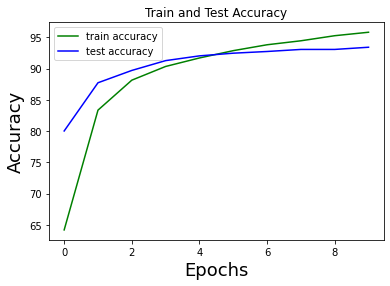

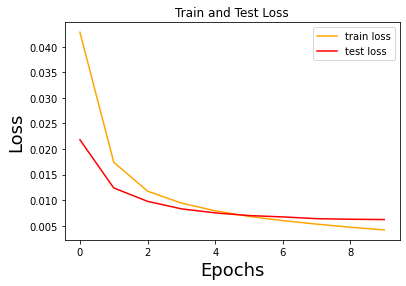

In [ ]:
# ResNet18 CNN
# May take up to an hour to run through 10 epochs
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc

# prevents error out of memory
gc.collect()
torch.cuda.empty_cache()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Image preprocessing modules
# crop to 224 X 224
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])



# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transform)      #transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# using ResNet
ResNet_model = torchvision.models.resnet18(pretrained=True)

input_features = ResNet_model.fc.in_features

ResNet_model.fc = nn.Sequential(nn.Linear(input_features, 1000),nn.ReLU(),nn.Linear(1000,10))

ResNet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ResNet_model.parameters(), lr=learning_rate)

print('\nCIFAR-10 ResNet18: \n')

def train_model(model, train_loader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # get image and label from data
        images = images.to(device)
        labels = labels.to(device)
        

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards propogate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)
    print('Train Loss: {:.4f}, Train Acc: {:.2f}'.format(train_loss, train_accuracy))
    
    return train_loss, train_accuracy


def evaluate_model(model, test_loader):
    model.eval()
    test_total_loss = 0.0
    test_total_correct = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_total_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        test_total_correct += (preds == labels).sum().item()
    
    test_avg_loss = test_total_loss/len(test_loader.dataset)
    test_accuracy = 100. * test_total_correct/len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Acc: {:.2f}'.format(test_avg_loss, test_accuracy))
    
    return test_avg_loss, test_accuracy

# train and evaluate model
train_loss , train_accuracy = [], []
test_loss , test_accuracy = [], []
for epoch in range(10):
    print('Epoch {}:'.format(epoch+1))
    train_epoch_loss, train_epoch_accuracy = train_model(ResNet_model, train_loader)
    test_epoch_loss, test_epoch_accuracy = evaluate_model(ResNet_model, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

# plot accuracy graphs
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(test_accuracy, color='blue', label='test accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

# plot loss graphs
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(test_loss, color='red', label='test loss')
plt.legend()
plt.title('Train and Test Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
# VGG16 CNN ****WARNING: Running this will take a very long time and chew up alot of VRAM**** 

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gc

# prevents error out of memory
gc.collect()
torch.cuda.empty_cache()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# resize CIFAR-10 images to 224x224
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# load VGG model
VGG_model = torchvision.models.vgg16(pretrained=True)

VGG_model.to(device)

# change the number of classes from 1000 to 10
VGG_model.classifier[6].out_features = num_classes

for param in VGG_model.features.parameters():
    param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(VGG_model.parameters(), lr=learning_rate)

print('\nCIFAR-10 VGG16: \n')

def train_model(model, train_loader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # get image and label from data
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()

        # backwards propogate and optimize
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)
    print('Train Loss: {:.4f}, Train Acc: {:.2f}'.format(train_loss, train_accuracy))
    
    return train_loss, train_accuracy


def evaluate_model(model, test_loader):
    model.eval()
    test_total_loss = 0.0
    test_total_correct = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_total_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        test_total_correct += (preds == labels).sum().item()
    
    test_avg_loss = test_total_loss/len(test_loader.dataset)
    test_accuracy = 100. * test_total_correct/len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Acc: {:.2f}'.format(test_avg_loss, test_accuracy))
    
    return test_avg_loss, test_accuracy

# train and evaluate model
train_loss , train_accuracy = [], []
test_loss , test_accuracy = [], []
for epoch in range(10):
    print('Epoch {}:'.format(epoch+1))
    train_epoch_loss, train_epoch_accuracy = train_model(VGG_model, train_loader)
    test_epoch_loss, test_epoch_accuracy = evaluate_model(VGG_model, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

# plot accuracy graphs
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(test_accuracy, color='blue', label='test accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

# plot loss graphs
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(test_loss, color='red', label='test loss')
plt.legend()
plt.title('Train and Test Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

Files already downloaded and verified

CIFAR-10 VGG16: 

Epoch 1:


KeyboardInterrupt: ignored